In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## 결론

- 자전거도로 중앙 노이즈에 약함
- HLS Space 로 바꾸지 않으면, 그림자에도 굉장히 약함
- 직선을 fitting 하는 것이 아니고, sliding window 기반이라면, 굉장히 느림
- 처음에 가이드된 구역 안에 차선의 좌우가 모두 들어와야 인식이 가능해서 유저에게 노동을 요구함 
- 즉, 초기 슬라이딩 윈도우 안정화가 필요하며, 카메라 각도는 흔들리면 안 되며 아주 잘 맞추어 놓아야 함.
- 이용자에게 가이드를 제공할 수 있어야 함.

2716451104048
2716451104128
(720, 1080, 3)


([<matplotlib.lines.Line2D at 0x2787926d630>],
 [<matplotlib.lines.Line2D at 0x2787926dd68>])

<Figure size 576x576 with 0 Axes>

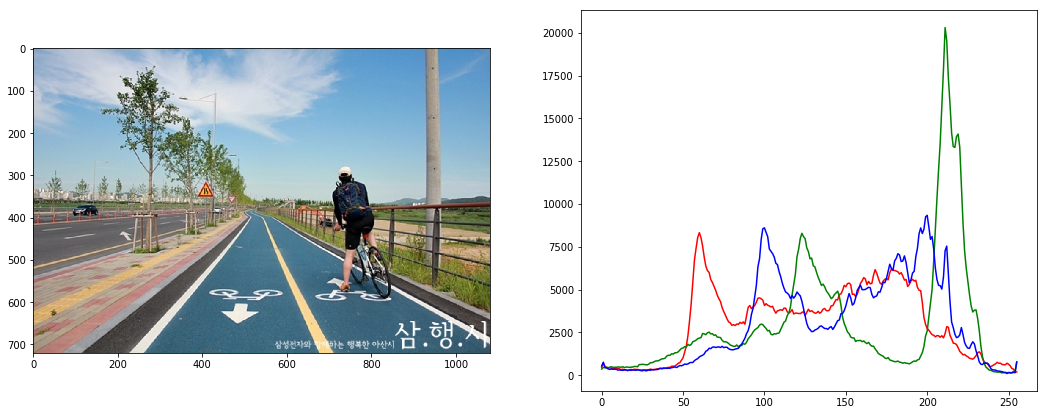

In [2]:
# Hyper parameter
#---------------------------------------
img_li = ['image/1.jpg', 'image/2.jpg', 'image/3.jpg', 'image/4.jpg']
img_nb = 3

IMAGE_WIDTH = 1080
IMAGE_HEIGHT = 720
#---------------------------------------

plt.figure(figsize = [8,8])
img = cv2.imread(img_li[img_nb], cv2.COLOR_BGR2RGB)
print(id(img))
img = cv2.resize(img, dsize=(IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_LINEAR)
print(id(img))
print(img.shape)

plt.figure(figsize = [18,7])
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
hist_g = cv2.calcHist([img],[0],None,[256],[0,256])
hist_b = cv2.calcHist([img],[1],None,[256],[0,256])
hist_r = cv2.calcHist([img],[2],None,[256],[0,256])
plt.plot(hist_r,color='red'), plt.plot(hist_g,color='green'), plt.plot(hist_b,color='blue')

## Edge Detection

### Sobel Filter

- remind : numpy is channel LAST

R min 0
R max 255
G min 0
G max 255
B min 0
B max 255


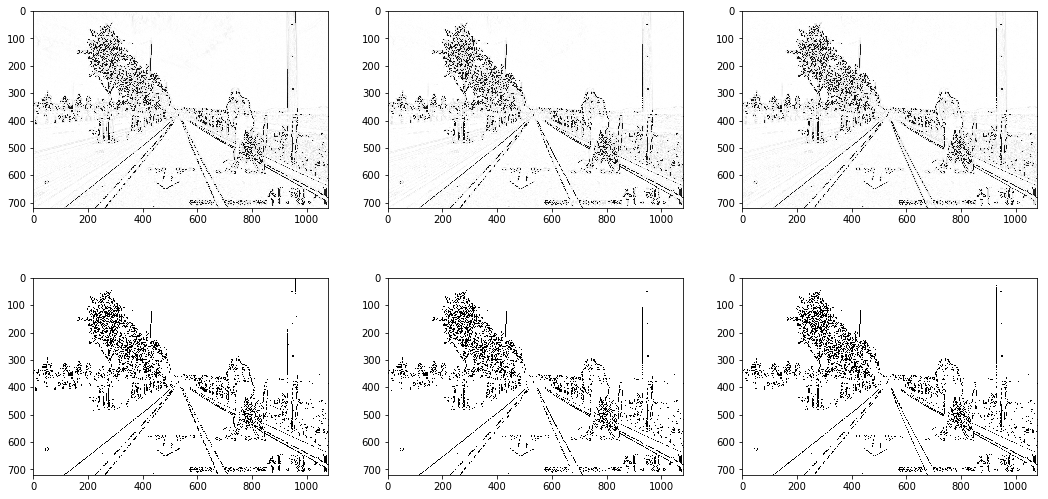

In [3]:
# Hyper parameter
#---------------------------------------
CUSTOM_GLOBAL_IMG_DATA_TYPE = cv2.CV_16S

sobelx_threshold_min = 35

sobelx_threshold_MAX = 255 
#---------------------------------------


sobelx_B = cv2.Sobel(img[:,:,0], CUSTOM_GLOBAL_IMG_DATA_TYPE, 1, 0) # Take the derivative in x
sobelx_G = cv2.Sobel(img[:,:,1], CUSTOM_GLOBAL_IMG_DATA_TYPE, 1, 0) # Take the derivative in x
sobelx_R = cv2.Sobel(img[:,:,2], CUSTOM_GLOBAL_IMG_DATA_TYPE, 1, 0) # Take the derivative in x

sobelx = {}
sobelx['R'] = sobelx_R
sobelx['G'] = sobelx_G
sobelx['B'] = sobelx_B
sobelx_mask = {}

for channel in sobelx :
    sobelx[channel] = np.absolute(sobelx[channel])
    sobelx[channel] = np.uint8((255 * sobelx[channel])/np.max(sobelx[channel]))
    print(channel, 'min', sobelx[channel].min())
    print(channel, 'max', sobelx[channel].max())
    
    sobelx_mask[channel] = np.zeros_like(sobelx[channel])
    sobelx_mask[channel][(sobelx[channel] >= sobelx_threshold_min) & (sobelx[channel] <= sobelx_threshold_MAX)] = 1

# row 1 : sobel, scaled
plt.figure(figsize = [18,9])
plt.subplot(2,3,1)
plt.imshow(sobelx['R'], cmap=plt.cm.binary)
plt.subplot(2,3,2)
plt.imshow(sobelx['G'], cmap=plt.cm.binary)
plt.subplot(2,3,3)
plt.imshow(sobelx['B'], cmap=plt.cm.binary)

# row 2 : sobel, thresholded
plt.subplot(2,3,4)
plt.imshow(sobelx_mask['R'], cmap=plt.cm.binary)
plt.subplot(2,3,5)
plt.imshow(sobelx_mask['G'], cmap=plt.cm.binary)
plt.subplot(2,3,6)
plt.imshow(sobelx_mask['B'], cmap=plt.cm.binary)

### RoI

### Bird's Eye View

### Testing

[[378.      432.00003]
 [702.      432.00003]
 [108.      720.     ]
 [972.      720.     ]]
[[   0.    0.]
 [1080.    0.]
 [   0.  720.]
 [1080.  720.]]
(720, 1080, 3)
[[   0.    0.]
 [1080.    0.]
 [   0.  720.]
 [1080.  720.]]

--- cutted location --- 
 [[378.      432.00003]
 [702.      432.00003]
 [108.      720.     ]
 [972.      720.     ]]


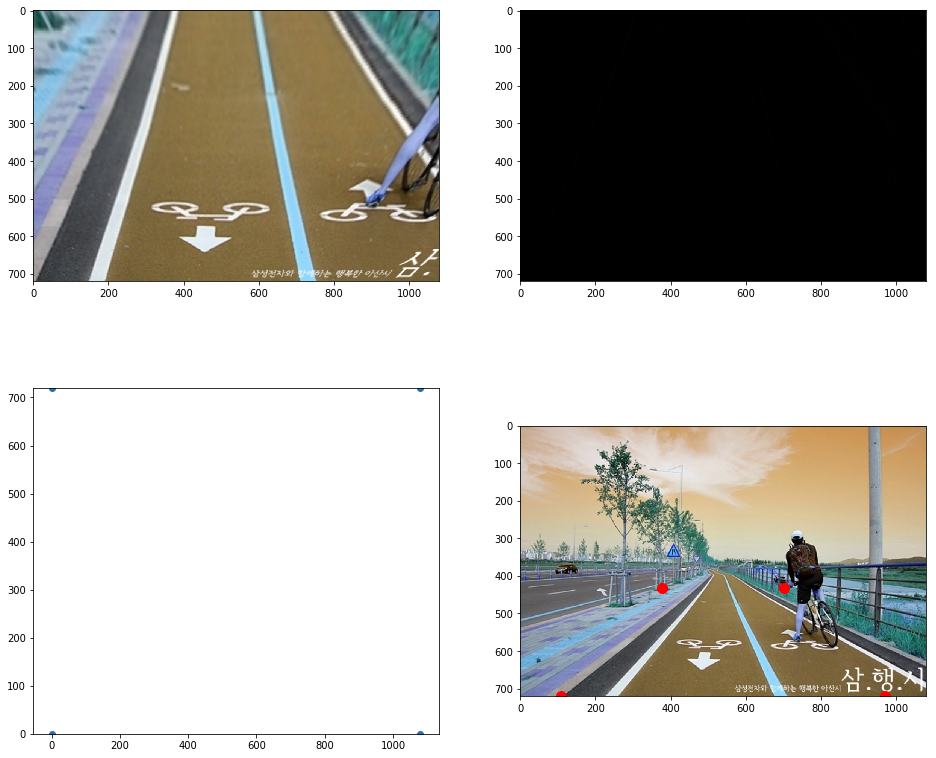

In [4]:
# Hyper parameter
#---------------------------------------
fullsize = np.float32([IMAGE_WIDTH,IMAGE_HEIGHT])
temp_loc_cutting = np.float32([(0.35,0.6),(0.65,0.6),(0.1,1),(0.9,1)])
temp_loc_full = np.float32([(0,0), (1, 0), (0,1), (1,1)])
#---------------------------------------

cutted_loc = temp_loc_cutting * fullsize
print(cutted_loc) # [1080*0.43, 720*0.65], [1080*0.58, 720*0.65], ... 
fullsized_loc = temp_loc_full * fullsize
print(fullsized_loc)
birdeye_kernel = cv2.getPerspectiveTransform(cutted_loc, fullsized_loc)

birdeye_img = cv2.warpPerspective(img, birdeye_kernel, (IMAGE_WIDTH, IMAGE_HEIGHT))
print(np.dstack([sobelx_mask['R'],sobelx_mask['G'],sobelx_mask['B']]).shape)
birdeye_sob_img = cv2.warpPerspective(np.dstack([sobelx_mask['R'],sobelx_mask['G'],sobelx_mask['B']]), birdeye_kernel, (IMAGE_WIDTH, IMAGE_HEIGHT))

plt.figure(figsize = [16,14])
plt.subplot(2,2,1)
plt.imshow(birdeye_img)

plt.subplot(2,2,2)
plt.imshow(birdeye_sob_img, cmap=plt.cm.binary)


# figure 3
src = np.float32([1080,720])
a = np.float32([(0,0), (1, 0), (0,1), (1,1)])
full = src*a
print(full)

plt.subplot(2,2,3)
plt.gca().invert_yaxis()
plt.ylim( 0, IMAGE_HEIGHT )
plt.scatter(full[:,0], full[:,1])


# figure 4
cut = src * temp_loc_cutting
print("\n--- cutted location --- \n", cut)

ax2 = plt.subplot(2,2,4)
plt.ylim( 0, IMAGE_HEIGHT )
plt.gca().invert_yaxis()
plt.scatter(cut[:,0], cut[:,1], color = 'red', s = 100)
plt.imshow(img)

# Testing

In [5]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    # img = undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


def perspective_warp(img, 
                     dst_size=(1080,720),
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def inv_perspective_warp(img, 
                     dst_size=(1080,720),
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary = pipeline(img)
dst = perspective_warp(binary, dst_size=(1080,720))

(2, 720)
(607.2473985878883, 3495.69469800692, 0.1514120723521852)
(720, 1080, 3)
(720, 1080, 3)


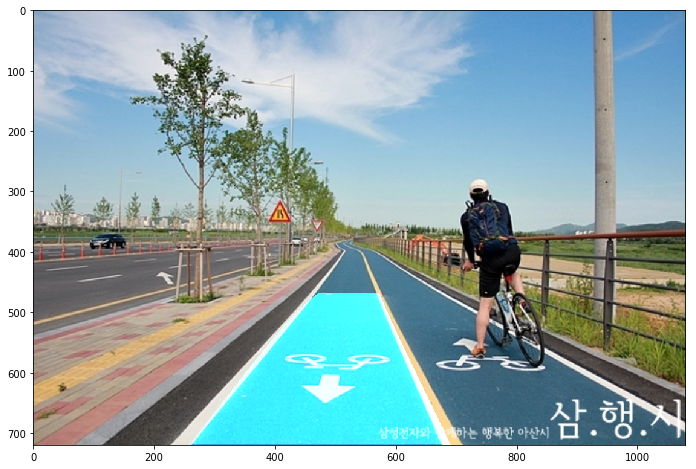

In [6]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
#        if len(good_right_inds) > minpix:        
#            rightx_current = np.int(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
#        elif len(good_left_inds) > minpix:
#            rightx_current = np.int(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
#        if len(good_left_inds) > minpix:
#            leftx_current = np.int(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
#        elif len(good_right_inds) > minpix:
#            leftx_current = np.int(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    print(inv_perspective.shape)
    print(img.shape)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective


def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist



plt.figure(figsize = [15,8])
out_img, curves, lanes, ploty = sliding_window(dst)
print(np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print(curverad)
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(img_, cmap='hsv')